# ACML Assignment 2
In this assignment a neural network is built from scratch and trained using backpropagation. The working of the neural network is then explored by experimenting with different activation functions and neural network architectures. The MNIST dataset is used in which images of handwritten digits are paired with their corresponding label. Given images of handwritten digits the actual digit is predicted.

## Neural Network Implementation
A customizable neural network framework is created which can run networks with any number of layers and any number of units within those layers. The framework also allows for a choice of which activation function will be used in the layers leading up to the final layer. The final layer uses a softmax regression function to make its prediction. 

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

In [28]:
# returns input matrix with a row of ones added
def add_row_ones(X):
    return np.append(np.ones((1, X.shape[1])), X, axis=0)

In [29]:
# Activation Functions
# each activation function is created here and passed into other functions when needed
# d_<activation function>(z) is the corresponding activation function's derivative


def sigmoid(z):
    return 1/(1+np.exp(-z))


def d_sigmoid(z):
    return (1-sigmoid(z))*(sigmoid(z))


def linear(z):
    return z


def d_linear(z):
    return 1


def tanh(z):
    return np.tanh(z)


def d_tanh(z):
    return (1-np.tanh(z)**2)


def ReLU(z):
    return np.maximum(0, z)


def d_ReLU(z):
    return np.maximum(0, z)/z


a_func_derivatives = {sigmoid: d_sigmoid,
                      linear: d_linear, tanh: d_tanh, ReLU: d_ReLU}

In [30]:
# softmax regression used for final layer of network


def softmax(z):
    e_z = np.exp(z-np.max(z))
    return e_z/sum(e_z)

In [31]:
# turns label into vector which has a one at index=label and 0s everywhere else


def label_to_vector(y, number_of_classes):
    y_new = np.zeros([number_of_classes, y.shape[0]])
    s = 0
    for i in range(len(y)):
        y_new[y[i]][i] = 1
    return y_new

In [32]:
# regularized cost function for a classification neural network


def cost(X, y, Thetas, a_func, lambd):
    _, A_vals = forward_prop(X, Thetas, a_func)
    h = A_vals[-1]
    n = X.shape[1]
    reg = 0
    for i in range(len(Thetas)):
        reg += sum(sum(Thetas[i][:, 1:]**2))
    reg *= lambd
    return (-1/n)*sum(sum((y*np.log(h)+(1-y)*np.log(1-h)))) + reg

In [33]:
# calculates the percentage of predictions that are correct
# given softmax output and the correct labels (y)


def percentage_accuracy(y, h):
    right = 0
    for i in range(h.shape[1]):
        if y[np.where(h[:, i] == max(h[:, i])), i] == 1:
            right = right+1
    return (right/h.shape[1])*100

In [34]:
# plots the cost at each epoch and prints other results


def show_results(X_train, y_train, X_test, y_test, Thetas, a_func, costs):
    plt.plot(costs)
    print('final cost: ', costs[-1])

    Z_vals, A_vals = forward_prop(X_train, Thetas, a_func)
    p_acc_train = percentage_accuracy(y_train, A_vals[-1])
    print("training set percentage accuracy = ",
          p_acc_train, '%')

    Z_vals, A_vals = forward_prop(X_test, Thetas, a_func)
    p_acc_test = percentage_accuracy(y_test, A_vals[-1])
    print("test set percentage accuracy = ",
          p_acc_test, '%')

    return p_acc_train, p_acc_test

### Notation and shapes clarification

Thetas include the bias term. 

each feature forms a row of X and each training example forms a column of X of X. (X.shape = num_features x num_examples)

each class forms a row of y and each training example forms a column of y. (y.shape = num_classes x num_examples)

Lists are used to save the values of the neural network in which each layer is represented by the index of the lists. The index starts at 0 (different to the mathematical notation which starts at 1). For example A_vals[0] is equivalent to the input layer written as $x$ or $a^{[1]}$. Similar logic applies for variables Thetas and Z_vals

In [35]:
def initialise_Thetas(layer_nums):
    # layer_nums: list with the amount of units in each hidden layer (excluding bias)
    # layer_nums includes input, hidden and output layers
    # (layer corresponds to index)
    Thetas = []
    # randomly initialise Thetas
    for i in range(1, len(layer_nums)):
        random = np.random.rand(layer_nums[i], layer_nums[i-1]+1)
        random = random * np.sqrt(2/(layer_nums[i-1]+1))
        Thetas.append(random)

    return Thetas

In [36]:
# propogates forward through the nueral network and returns all values of Z
# and the activations A it finds along the way
# index of lists represent layer (starting at 0)


def forward_prop(X, Thetas, a_func):
    A_vals = [X]
    Z_vals = [None]  # no Z_val for first layer

    # feed forward using given activation function
    for i in range(len(Thetas)-1):
        A_vals[-1] = add_row_ones(A_vals[-1])
        Z_vals.append(np.dot(Thetas[i], A_vals[-1]))
        A_vals.append(a_func(Z_vals[-1]))

    # using softmax regression for final layer
    A_vals[-1] = add_row_ones(A_vals[-1])
    Z_vals.append(np.dot(Thetas[-1], A_vals[-1]))
    A_vals.append(softmax(Z_vals[-1]))

    return Z_vals, A_vals

In [37]:
# vectorised implementation of back prop.
# loops only used to loop through layers.
# Which therefore allows for a variable number of layers


def back_prop(y, Z_vals, A_vals, Thetas, n, d_a_func, lambd):

    # deltas is initialised since we find the elements in the reverse order of the list
    deltas = [None]*(len(Thetas)+1)

    grads = []
    deltas[-1] = A_vals[-1]-y

    for i in reversed(range(1, len(Thetas))):
        dg = d_a_func(Z_vals[i])  # derivative of activation function
        deltas[i] = np.transpose(Thetas[i][:, 1:])@deltas[i+1]*dg

    Ds = []  # stores Gradient matrices D for each layer (same shape as Thetas)
    for i in range(len(Thetas)):
        grads.append(deltas[i+1]@np.transpose(A_vals[i]))
        D = (1/n)*grads[i]
        # regularization (excluding bias)
        D[:, 1:] = D[:, 1:] + lambd*Thetas[i][:, 1:]
        Ds.append(D)

    return Ds

In [38]:
# trains the nn for a given amount of iterations


def train_nn(NN_architecture, X_train, y_train, a_func, iterations, lr, lambd):
    costs = []
    # initialising Theta based on given neural network architecture
    Thetas = initialise_Thetas(NN_architecture)
    # derivative of the given activation function
    d_a_func = a_func_derivatives[a_func]

    for i in range(iterations):
        # loading bar for training. complete after a maximum of 100 dots
        if i % int(iterations/100) == 0:
            print('.', end="")

        # forward propogation
        Z_vals, A_vals = forward_prop(X_train, Thetas, a_func)

        # storing all costs for plot
        costs.append(cost(X_train, y_train, Thetas, a_func, lambd))

        # back propogation
        D = back_prop(y_train, Z_vals, A_vals, Thetas,
                      X_train.shape[1], d_a_func, lambd)

        # updating Thetas
        for i in range(len(Thetas)):
            Thetas[i] = Thetas[i] - lr*D[i]
    print()  # to end line
    return Thetas, costs

In [39]:
# read in data - takes quite long since the dataset is large (took about 30 seconds for me)
df_train = pd.read_csv('mnist_train.csv',
                       sep=r'\s*,\s*', engine='python')
df_test = pd.read_csv('mnist_test.csv',
                      sep=r'\s*,\s*', engine='python')

In [40]:
# data handling
num_classes = 10

# create numpy matrices
# only used the first 2500 training examples to speed up training
# alot can still be learned from the first 2500

X_train = np.transpose(df_train.drop('label', axis=1).to_numpy())[:, :2500]
X_test = np.transpose(df_test.drop('label', axis=1).to_numpy())

X_train = X_train/255
X_test = X_test/255

y_train_label = np.transpose(df_train['label'].to_numpy())[:2500]
y_test_label = np.transpose(df_test['label'].to_numpy())
y_train = label_to_vector(y_train_label, num_classes)
y_test = label_to_vector(y_test_label, num_classes)

## Exploring Activation Functions
In this section neural networks are trained with different activation functions and compared. The network architecture that worked best (found in the 'Exploring NN architectures' section below) is a network that contains a single hidden layer of 25 units. This architecture will be used for all experiments in this section. When training, a dot is printed after a certain amount of epochs such that after 100 dots the training will be done (loading bar).
### Sigmoid
A sigmoid activation function is used as a base below and  returns a high accuracy of around 96% for the training set and 90% for the test set

....................................................................................................
final cost:  0.6395527291060648
training set percentage accuracy =  96.44 %
test set percentage accuracy =  89.81 %


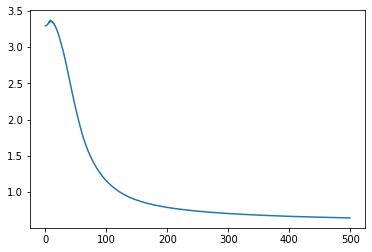

In [42]:
NN_architecture = [784, 25, 10]
iterations = 500
lr = 1
lambd = 0.001
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, sigmoid, iterations, lr, lambd)
acc_train_sigmoid, acc_test_sigmoid = show_results(
    X_train, y_train, X_test, y_test, Thetas, sigmoid, costs)
sigmoid_cost = costs[-1]

### ReLU
Using the RelU activation function it was found that a lower learning rate was needed. It returns a lower accuracy than the sigmoid of around 93% for the training set and 89% for the test set

....................................................................................................
final cost:  0.4817647478586972
training set percentage accuracy =  93.60000000000001 %
test set percentage accuracy =  89.18 %


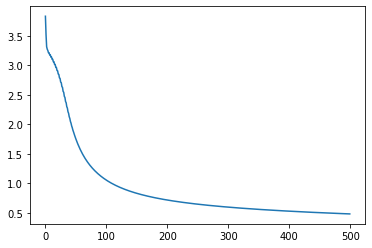

In [43]:
NN_architecture = [784, 25, 10]
iterations = 500
lr = 0.1
lambd = 0.001
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, ReLU, iterations, lr, lambd)
acc_train_relu, acc_test_relu = show_results(
    X_train, y_train, X_test, y_test, Thetas, ReLU, costs)
relu_cost = costs[-1]

### Linear
A linear activation function is used in which the input of the function is equal to the output (identity). It provided surprisingly high results. I therefore checked its validity by attempting to see if an sklearn model could produce similarly high results.

....................................................................................................
final cost:  0.5230488331531753
training set percentage accuracy =  93.04 %
test set percentage accuracy =  88.96 %


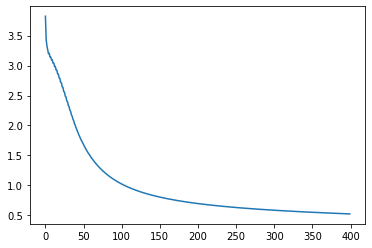

In [44]:
NN_architecture = [784, 25, 10]
iterations = 400
lr = 0.1
lambd = 0.001
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, linear, iterations, lr, lambd)
acc_train_linear, acc_test_linear = show_results(
    X_train, y_train, X_test, y_test, Thetas, linear, costs)
linear_cost = costs[-1]

The code below was used to verify that a NN with a linear activation could produce the high results that were found in my implementation. It can be seen below that a pre-built also achieves high results with 91% accuracy. This therefore illustrates that the dataset is actually quite linearly separable. 

In [46]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(
    25), activation='identity', solver='adam', max_iter=100)
mlp.fit(np.transpose(X_train), np.transpose(y_train))

predict_train = np.transpose(mlp.predict(np.transpose(X_train))).astype(float)

#had to use different percentage accuracy code as sk learn prediction is in a different form
right = 0
for i in range(y_train.shape[1]):
    if (predict_train[:, i] == y_train[:, i]).all():
        right += 1
print('sk learn linear percentage accuracy:',
      (right/y_train.shape[1])*100, '%')

sk learn linear percentage accuracy: 91.84 %


/home/thishen/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### Tanh
The Tanh function performed very well on the training set with an accuracy of around 99%. It also performed well achieving the highest accuracy on the test set

....................................................................................................
final cost:  0.27163027064188144
training set percentage accuracy =  99.68 %
test set percentage accuracy =  90.45 %


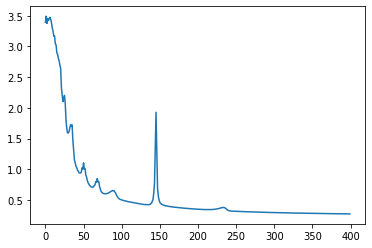

In [47]:
NN_architecture = [784, 25, 10]
iterations = 400
lr = 1
lambd = 0.001
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, tanh, iterations, lr, lambd)
acc_train_tanh, acc_test_tanh = show_results(
    X_train, y_train, X_test, y_test, Thetas, tanh, costs)
tanh_cost = costs[-1]

### Comparing The Functions
It can be seen below that the Tanh activation function converges to the lowest point while the sigmoid function performs the worst in terms of it's final cost. We can conclude that the Tanh function performs best for this dataset and architecture as it performed the best in both training set metrics and test set metrics.

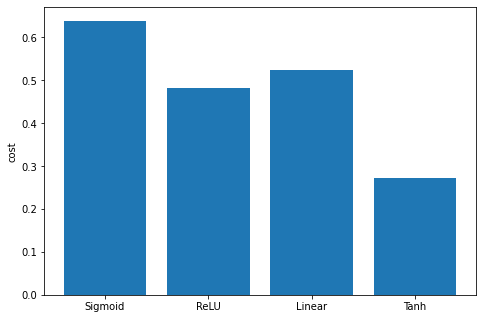

In [48]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
funcs = ['Sigmoid', 'ReLU', 'Linear', 'Tanh']
values = [sigmoid_cost, relu_cost, linear_cost, tanh_cost]
ax.bar(funcs, values)
plt.ylabel("cost")
plt.show()

## Exploring NN Architectures
In this section we train neural networks of various depths with various numbers of units in each layer. All using the sigmoid activation function
### Simple Neural Network
The first network that will be trained has a single hidden layer containing 3 nodes (not including the bias node). It can be seen by the results below that the network learns a reasonable accuracy for the training set of around 70% and around 60% for the test set. The network is successfully learning but it can be improved.

....................................................................................................
final cost:  1.6094122722180528
training set percentage accuracy =  73.4 %
test set percentage accuracy =  66.9 %


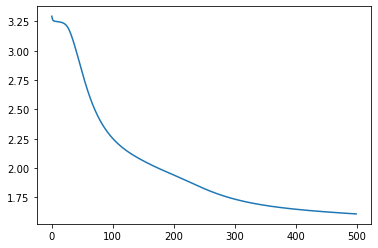

In [49]:
NN_architecture = [784, 3, 10]
iterations = 500
lr = 1
lambd = 0.001
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, sigmoid, iterations, lr, lambd)
acc_train, acc_test = show_results(X_train, y_train, X_test, y_test, Thetas, sigmoid, costs)

### Deeper Neural Network
The second network we will train contains 3 hidden layers which each contain 3 units. It was found from training, that deeper networks may be more susceptible to finding a local optima and converging at a below par cost. This may be due to the fact that it is learning a more complex function which cause there to be more local optima points that it could fall into. This phenomena can be seen below with the Neural network converging at a cost of around 3.25 and accuracy below 15%. 

....................................................................................................
final cost:  3.251525262746984
training set percentage accuracy =  11.200000000000001 %
test set percentage accuracy =  9.82 %


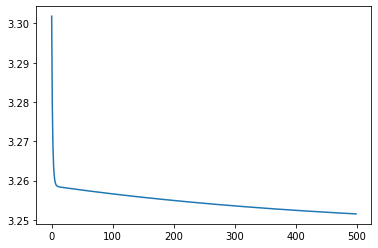

In [50]:
NN_architecture = [784, 3, 3, 3, 10]
iterations = 500
lr = 1
lambd = 0.001
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, sigmoid, iterations, lr, lambd)
acc_train, acc_test = show_results(X_train, y_train, X_test, y_test, Thetas, sigmoid, costs)

### Neural Network with More Units
The next Neural network to be trained is consists of one hidden layer containing 25 units. Adding more units to the layer allowed for more complex functions to be learned. It found a suitable cost minimum of around 0.6 and accuracies of about 97 and 90 percent for the training set and test set respectively. There was a difference of about 7% between test and training accuracies

....................................................................................................
final cost:  0.2391390912266198
training set percentage accuracy =  97.28 %
test set percentage accuracy =  90.25 %


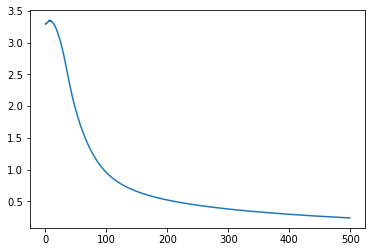

In [51]:
NN_architecture = [784, 25, 10]
iterations = 500
lr = 1
lambd = 0
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, sigmoid, iterations, lr, lambd)
acc_train, acc_test = show_results(X_train, y_train, X_test, y_test, Thetas, sigmoid, costs)

### Deeper Neural network with More Units 
finally we train a Neural network of 2 hidden layers each containing 25 units. It was found below that since the network is more complicated it had to be trained for a longer. It was found to better fit the training set but perform worse on the test set than the previous network. The difference accuracy of test and training was around 10%. 

It can therefore be concluded that the depth of the layer can improve accuracy on training set predictions but at the same time causes the model to be less generalizable.

....................................................................................................
final cost:  0.03697206331971535
training set percentage accuracy =  99.92 %
test set percentage accuracy =  88.73 %


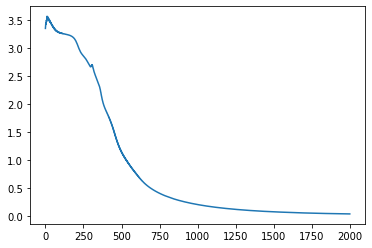

In [52]:
NN_architecture = [784, 25, 25, 10]
iterations = 2000
lr = 1
lambd = 0
Thetas, costs = train_nn(NN_architecture, X_train,
                         y_train, sigmoid, iterations, lr, lambd)
acc_train, acc_test = show_results(X_train, y_train, X_test, y_test, Thetas, sigmoid, costs)

## Conclusion
it was found that the Tanh functions performs best for this type of data within this architecture. It was also found that a shallow architecture with many units in a single hidden performed best on this type of data 